In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt

from datetime import date, datetime, timedelta

In [2]:
df_stock_ta = pd.read_csv('temp/stock_ta.csv')
df_stock_cdl = pd.read_csv('temp/stock_cdl.csv')
df_ind_ta = pd.read_csv('temp/ind_ta.csv')
df_ind_cdl = pd.read_csv('temp/ind_cdl.csv')
df_stock_news = pd.read_csv('temp/stock_news.csv')
df_ind_news = pd.read_csv('temp/ind_news.csv')

df_tar = pd.read_csv('temp/target.csv')
df_tar = df_tar[['report_date', 'ticker', 'label']]
# df_stock_ta = df_stock_ta.drop(['open', 'high', 'low', 'close', 'volume', 'adjusted_close'], axis = 1)
# df_ind_ta = df_ind_ta.drop(['open', 'high', 'low', 'close', 'volume', 'adjusted_close'], axis = 1)

# Prepare Cross Industrial Feature
df_inds = df_ind_cdl.merge(df_ind_news, on = ['inds', 'report_date'], how = 'left')
df_inds = df_inds.merge(df_ind_ta, on = ['report_date', 'inds'])
df_inds = df_inds.fillna(method = 'ffill')

In [3]:
df_inds['inds'].unique()

array(['Industrials', 'Health Care', 'Information Technology',
       'Communication Services', 'Consumer Staples',
       'Consumer Discretionary', 'Utilities', 'Financials', 'Materials',
       'Real Estate', 'Energy'], dtype=object)

In [4]:
period = 7; train_size = 0.8; prepare_3d = True
require_features = ['cdl', 'ta', 'news']
inds_num = len(df_inds['inds'].unique())

price_cols = ['open', 'high', 'low', 'close', 'volume']
cdl_cols = ['morning_star', 'evening_star', 'hammer',
       'inverted_hammer', 'bullish_engulfing', 'bearish_engulfing',
       'shooting_star', 'hanging_man']
news_cols = ['compound', 'neg', 'neu', 'pos', 'new_cases',
       'total_cases', 'total_deaths', 'new_deaths', 'total_deaths_nd']
ta_cols = df_stock_ta.drop(['report_date', 'ticker'], axis = 1).columns

In [5]:
# Prepare Train test dataset preparation
X_train, y_train, X_test, y_test = [], [], [], []

stocks = df_tar['ticker'].unique()
for stock in stocks:
    
    print('Current Stock: ', stock)
    temp_stock_cdl = df_stock_cdl[df_stock_cdl['ticker'] == stock]
    temp_stock_ta = df_stock_ta[df_stock_ta['ticker'] == stock]
    temp_stock_news = df_stock_news[df_stock_news['ticker'] == stock]
    temp_stock_tar = df_tar[df_tar['ticker'] == stock]
    
    # Merge results
    data = temp_stock_tar.merge(temp_stock_cdl, on = ['report_date', 'ticker'])
    data = data.merge(temp_stock_ta, on = ['report_date', 'ticker'])
    data = data.merge(temp_stock_news, on = ['report_date', 'ticker'], how = 'left')
    data = data.fillna(method = 'ffill')
    
    check = True
    for i in range(period, len(data)):
        
        temp = []
        # Create historical data (within period)
        temp_period = data.iloc[i - period:i,]
        if temp_period.isnull().sum().sum() > 0:
            continue

        # Create stock feature space
        feature_dfs = []
        feature_dfs.append(temp_period[price_cols])
        
        if 'cdl' in require_features:
            feature_dfs.append(temp_period[cdl_cols])
            
        if 'news' in require_features:
            feature_dfs.append(temp_period[news_cols])
            
        if 'ta' in require_features:
            feature_dfs.append(temp_period[ta_cols])
            
        temp_stock_feature = pd.concat(feature_dfs, axis = 1).to_numpy()
        temp.append(temp_stock_feature)
        
        # Get industrial feature space
        for ind in sorted(list(df_inds['inds'].unique())):
            temp_period_inds = df_inds[df_inds['inds'] == ind].reset_index(drop = True).iloc[i - period:i,]
            
            feature_ind_dfs = []
            feature_ind_dfs.append(temp_period_inds[price_cols])
            if 'cdl' in require_features:
                feature_ind_dfs.append(temp_period_inds[cdl_cols])

            if 'news' in require_features:
                feature_ind_dfs.append(temp_period_inds[news_cols])

            if 'ta' in require_features:
                feature_ind_dfs.append(temp_period_inds[ta_cols])
                
            temp_ind_feature = pd.concat(feature_ind_dfs, axis = 1).to_numpy()
            temp.append(temp_ind_feature)
        
        # Create label 
        y_label = temp_period.iloc[-1]['label']
        
        if i <= int((len(data) - period) * train_size):
            
#             if check:
#                 print('train', i)
#                 print('max report_date: ', max(temp_period['report_date']), 'min report_date: ', min(temp_period['report_date']))
#                 print('Whole feature shape: ', np.array(temp).shape)
#                 print('label: ', y_label)
#                 check = False

            X_train.append(temp)
            y_train.append(y_label)
        else: 
            X_test.append(temp)
            y_test.append(y_label)
        
X_train, y_train = np.array(X_train).astype('float32'), np.array(y_train)
X_test, y_test = np.array(X_test).astype('float32'), np.array(y_test)

Current Stock:  MMM
Current Stock:  AOS
Current Stock:  ABT
Current Stock:  ABBV
Current Stock:  ABMD
Current Stock:  ACN
Current Stock:  ATVI
Current Stock:  ADM
Current Stock:  ADBE
Current Stock:  ADP
Current Stock:  AAP
Current Stock:  AES
Current Stock:  AFL
Current Stock:  A
Current Stock:  APD
Current Stock:  AKAM
Current Stock:  ALK
Current Stock:  ALB
Current Stock:  ARE
Current Stock:  ALGN
Current Stock:  ALLE
Current Stock:  LNT
Current Stock:  ALL
Current Stock:  GOOGL
Current Stock:  GOOG
Current Stock:  MO
Current Stock:  AMZN
Current Stock:  AMCR
Current Stock:  AMD
Current Stock:  AEE
Current Stock:  AAL
Current Stock:  AEP
Current Stock:  AXP
Current Stock:  AIG
Current Stock:  AMT
Current Stock:  AWK
Current Stock:  AMP
Current Stock:  ABC
Current Stock:  AME
Current Stock:  AMGN
Current Stock:  APH
Current Stock:  ADI
Current Stock:  ANSS
Current Stock:  AON
Current Stock:  APA
Current Stock:  AAPL
Current Stock:  AMAT
Current Stock:  APTV
Current Stock:  ANET
Curre

Current Stock:  RCL
Current Stock:  SPGI
Current Stock:  CRM
Current Stock:  SBAC
Current Stock:  SLB
Current Stock:  STX
Current Stock:  SEE
Current Stock:  SRE
Current Stock:  NOW
Current Stock:  SHW
Current Stock:  SBNY
Current Stock:  SPG
Current Stock:  SWKS
Current Stock:  SJM
Current Stock:  SNA
Current Stock:  SEDG
Current Stock:  SO
Current Stock:  LUV
Current Stock:  SWK
Current Stock:  SBUX
Current Stock:  STT
Current Stock:  STE
Current Stock:  SYK
Current Stock:  SIVB
Current Stock:  SYF
Current Stock:  SNPS
Current Stock:  SYY
Current Stock:  TMUS
Current Stock:  TROW
Current Stock:  TTWO
Current Stock:  TPR
Current Stock:  TGT
Current Stock:  TEL
Current Stock:  TDY
Current Stock:  TFX
Current Stock:  TER
Current Stock:  TSLA
Current Stock:  TXN
Current Stock:  TXT
Current Stock:  TMO
Current Stock:  TJX
Current Stock:  TSCO
Current Stock:  TT
Current Stock:  TDG
Current Stock:  TRV
Current Stock:  TRMB
Current Stock:  TFC
Current Stock:  TWTR
Current Stock:  TYL
Current

In [6]:
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (109349, 12, 7, 38)
y_train shape:  (109349,)
X_test shape:  (42488, 12, 7, 38)
y_test shape:  (42488,)


In [10]:
# Divide to multiple combinations
cond_dict = {}
feature_idx_dict = {name: ind for ind, name in enumerate(pd.concat(feature_dfs, axis = 1).columns)}
# adj_news_cols = ['compound', 'pos', 'new_deaths', 'total_deaths_nd']
adj_news_cols = ['compound', 'pos', 'new_deaths']

# Candlestick + TA + News
feature_idx = [idx for name, idx in feature_idx_dict.items() \
                   if name in price_cols + cdl_cols + adj_news_cols + list(ta_cols)]
cond_dict['All'] = {'train': X_train[:, :, :, feature_idx], 'test': X_test[:, :, :, feature_idx]}

# Candlestick + News
feature_idx = [idx for name, idx in feature_idx_dict.items() if name in price_cols + cdl_cols + adj_news_cols]
cond_dict['Candlestick+News'] = {'train': X_train[:, :, :, feature_idx], 'test': X_test[:, :, :, feature_idx]}

# Candlestick + TA
feature_idx = [idx for name, idx in feature_idx_dict.items() if name in price_cols + cdl_cols + list(ta_cols)]
cond_dict['Candlestick+TA'] = {'train': X_train[:, :, :, feature_idx], 'test': X_test[:, :, :, feature_idx]}

# Candlestick Only
feature_idx = [idx for name, idx in feature_idx_dict.items() if name in price_cols + cdl_cols]
cond_dict['CandlestickOnly'] = {'train': X_train[:, :, :, feature_idx], 'test': X_test[:, :, :, feature_idx]}

# Use Conv3D

# Find the best model architecture

In [43]:
# # Determine structure
# def cnn(input_shape):
    
#     model = models.Sequential()
#     model.add(layers.Conv3D(32, (input_shape[0], input_shape[1], input_shape[2]),\
#                             activation = 'relu', input_shape = input_shape))
#     model.add(layers.Flatten())
#     model.add(layers.Dense(64, activation = 'relu'))
#     model.add(layers.Dense(1, activation = 'sigmoid'))
    
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#     return model

# for i in range(5):
#     epoch = 3
#     data = cond_dict['All']
#     temp_train = data['train']
#     temp_test = data['test']

#     train_shape = temp_train.shape
#     temp_train = temp_train.reshape(train_shape[0], train_shape[1], train_shape[2], train_shape[3], 1)
#     test_shape = temp_test.shape
#     temp_test = temp_test.reshape(test_shape[0], test_shape[1], test_shape[2], test_shape[3], 1)

#     dim = (temp_train.shape[1], temp_train.shape[2], temp_train.shape[3], temp_train.shape[4])
#     model = cnn(dim)
#     model.fit(temp_train, y_train, epochs=epoch)

#     training_acc = model.evaluate(temp_train, y_train)
#     testing_acc = model.evaluate(temp_test, y_test)

#     print(f'Training Accuracy for {i}: ', training_acc)
#     print(f'Testing Accuracy for {i}: ', testing_acc)

Epoch 1/3


2022-11-09 17:08:20.863929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3418/3418 [==============================] - 31s 9ms/step - loss: 0.6764 - accuracy: 0.6504
Epoch 2/3
3418/3418 [==============================] - 30s 9ms/step - loss: 0.6188 - accuracy: 0.6869
Epoch 3/3
  20/3418 [..............................] - ETA: 18s - loss: 0.5036 - accuracy: 0.7594

2022-11-09 17:09:52.927343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1328/1328 [==============================] - 6s 5ms/step - loss: 0.7122 - accuracy: 0.5986
Training Accuracy for 0:  [0.5861005783081055, 0.7036004066467285]
Testing Accuracy for 0:  [0.7122401595115662, 0.5985925793647766]
Epoch 1/3


2022-11-09 17:10:17.003649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3418/3418 [==============================] - 31s 9ms/step - loss: 0.6686 - accuracy: 0.6551
Epoch 2/3
3418/3418 [==============================] - 30s 9ms/step - loss: 0.6158 - accuracy: 0.6895
Epoch 3/3
   9/3418 [..............................] - ETA: 22s - loss: 0.5372 - accuracy: 0.6944 

2022-11-09 17:11:49.721239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1328/1328 [==============================] - 6s 5ms/step - loss: 0.6444 - accuracy: 0.6699
Training Accuracy for 1:  [0.5752258896827698, 0.706444501876831]
Testing Accuracy for 1:  [0.6443780064582825, 0.669859766960144]
Epoch 1/3


2022-11-09 17:12:13.764620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3418/3418 [==============================] - 31s 9ms/step - loss: 0.6767 - accuracy: 0.6529
Epoch 2/3
3418/3418 [==============================] - 31s 9ms/step - loss: 0.6225 - accuracy: 0.6861
Epoch 3/3
   9/3418 [..............................] - ETA: 22s - loss: 0.5506 - accuracy: 0.7049  

2022-11-09 17:13:46.373962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1328/1328 [==============================] - 6s 5ms/step - loss: 0.6967 - accuracy: 0.5979
Training Accuracy for 2:  [0.5882157683372498, 0.6933945417404175]
Testing Accuracy for 2:  [0.6966813802719116, 0.597862958908081]
Epoch 1/3


2022-11-09 17:14:13.455936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3418/3418 [==============================] - 29s 8ms/step - loss: 0.6772 - accuracy: 0.6507
Epoch 2/3
3418/3418 [==============================] - 28s 8ms/step - loss: 0.6136 - accuracy: 0.6849
Epoch 3/3
   9/3418 [..............................] - ETA: 22s - loss: 0.5132 - accuracy: 0.7014 

2022-11-09 17:15:40.231190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1328/1328 [==============================] - 6s 4ms/step - loss: 0.6576 - accuracy: 0.6492
Training Accuracy for 3:  [0.5685754418373108, 0.7079168558120728]
Testing Accuracy for 3:  [0.6575773358345032, 0.6492186188697815]
Epoch 1/3
   1/3418 [..............................] - ETA: 20:13 - loss: 0.7407 - accuracy: 0.5000

2022-11-09 17:16:02.983700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3418/3418 [==============================] - 29s 8ms/step - loss: 0.6767 - accuracy: 0.6529
Epoch 2/3
3418/3418 [==============================] - 28s 8ms/step - loss: 0.6124 - accuracy: 0.6896
Epoch 3/3
   9/3418 [..............................] - ETA: 22s - loss: 0.5471 - accuracy: 0.6944 

2022-11-09 17:17:30.037035: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1328/1328 [==============================] - 6s 4ms/step - loss: 0.6635 - accuracy: 0.6414
Training Accuracy for 4:  [0.5651547312736511, 0.7145287394523621]
Testing Accuracy for 4:  [0.6635291576385498, 0.6413811445236206]


# Find the optimal epochs

In [1]:
# def cnn(input_shape):
    
#     model = models.Sequential()
#     model.add(layers.Conv3D(32, (input_shape[0], input_shape[1], input_shape[2]),\
#                             activation = 'relu', input_shape = input_shape))
#     model.add(layers.Flatten())
#     model.add(layers.Dense(64, activation = 'relu'))
#     model.add(layers.Dense(1, activation = 'sigmoid'))
    
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#     return model

# for epoch in [3, 5,10, 15]:

#     training_acc_list = []; testing_acc_list = []
#     for i in range(3):
#         data = cond_dict['All']
#         temp_train = data['train']
#         temp_test = data['test']

#         train_shape = temp_train.shape
#         temp_train = temp_train.reshape(train_shape[0], train_shape[1], train_shape[2], train_shape[3], 1)
#         test_shape = temp_test.shape
#         temp_test = temp_test.reshape(test_shape[0], test_shape[1], test_shape[2], test_shape[3], 1)

#         dim = (temp_train.shape[1], temp_train.shape[2], temp_train.shape[3], temp_train.shape[4])
#         model = cnn(dim)
#         model.fit(temp_train, y_train, epochs=epoch, validation_split = 0.2)

#         training_acc = model.evaluate(temp_train, y_train)[1]
#         testing_acc = model.evaluate(temp_test, y_test)[1]
        
#         training_acc_list.append(training_acc); testing_acc_list.append(testing_acc)

#     print(f'Training Accuracy for {epoch}: ', np.mean(training_acc_list), training_acc_list)
#     print(f'Testing Accuracy for {epoch}: ', np.mean(testing_acc_list), testing_acc_list)

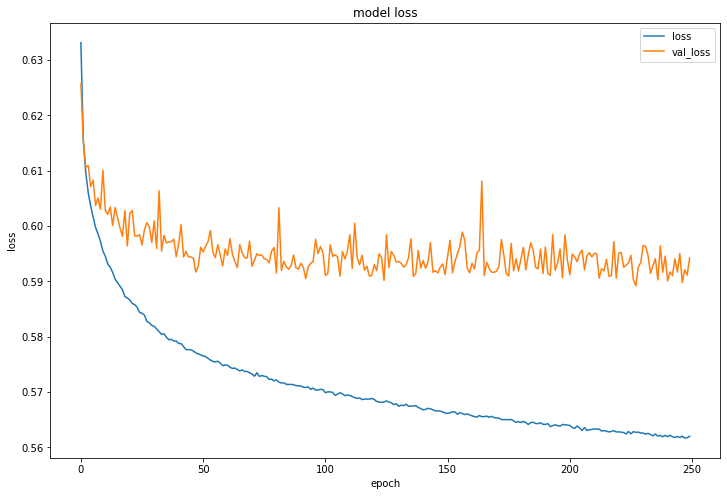

In [17]:
# summarize history for loss
fig = plt.figure(figsize = (12, 8))

plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')

plt.legend()
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
plt.show()

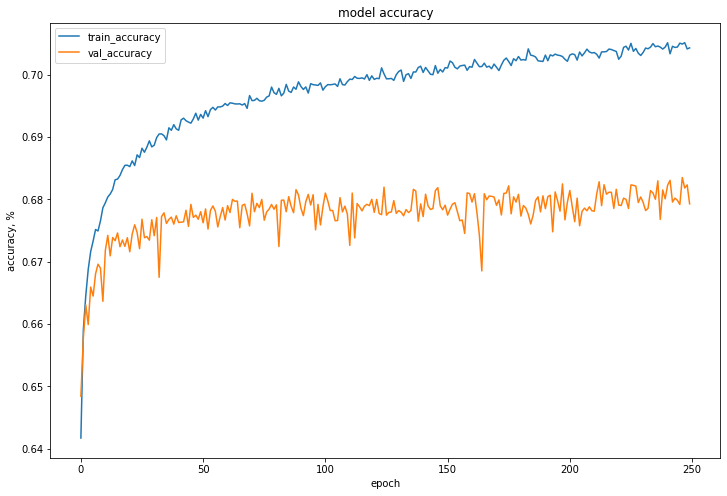

In [21]:
# summarize history for accuracy
fig = plt.figure(figsize = (12, 8))

plt.plot(history.history['accuracy'], label = 'train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')

plt.legend()
plt.title('model accuracy')
plt.ylabel('accuracy, %')
plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [85]:
def cnn(input_shape):
    
    model = models.Sequential()
    model.add(layers.Conv3D(32, (input_shape[0], input_shape[1], input_shape[2]),\
                            activation = 'relu', input_shape = input_shape))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation = 'relu'))
    model.add(layers.Dense(1, activation = 'sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

data = cond_dict['All']
temp_train = data['train']

train_shape = temp_train.shape
temp_train = temp_train.reshape(train_shape[0], train_shape[1], train_shape[2], train_shape[3], 1)
dim = (temp_train.shape[1], temp_train.shape[2], temp_train.shape[3], temp_train.shape[4])
model = cnn(dim)
print(train_shape)
model.summary()

(109349, 12, 7, 32)
Model: "sequential_100"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_94 (Conv3D)          (None, 1, 1, 1, 32)       86048     
                                                                 
 flatten_104 (Flatten)       (None, 32)                0         
                                                                 
 dense_242 (Dense)           (None, 64)                2112      
                                                                 
 dense_243 (Dense)           (None, 1)                 65        
                                                                 
Total params: 88,225
Trainable params: 88,225
Non-trainable params: 0
_________________________________________________________________


## Train different feature type

In [50]:
def cnn(input_shape):
    
    model = models.Sequential()
    model.add(layers.Conv3D(32, (input_shape[0], input_shape[1], input_shape[2]),\
                            activation = 'relu', input_shape = input_shape))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation = 'relu'))
    model.add(layers.Dense(1, activation = 'sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

epoch = 5
for feature_type, data in cond_dict.items():

    print(f'---- {feature_type} ----')
    
    training_acc_list = []; testing_acc_list = []
    for i in range(3):
        temp_train = data['train']
        temp_test = data['test']

        train_shape = temp_train.shape
        temp_train = temp_train.reshape(train_shape[0], train_shape[1], train_shape[2], train_shape[3], 1)
        test_shape = temp_test.shape
        temp_test = temp_test.reshape(test_shape[0], test_shape[1], test_shape[2], test_shape[3], 1)

        dim = (temp_train.shape[1], temp_train.shape[2], temp_train.shape[3], temp_train.shape[4])
        model = cnn(dim)
        model.fit(temp_train, y_train, epochs=epoch)

        training_acc = model.evaluate(temp_train, y_train)[1]
        testing_acc = model.evaluate(temp_test, y_test)[1]
        
        training_acc_list.append(training_acc); testing_acc_list.append(testing_acc)

    print(f'Training Accuracy for {epoch}: ', np.mean(training_acc_list), training_acc_list)
    print(f'Testing Accuracy for {epoch}: ', np.mean(testing_acc_list), testing_acc_list)

---- All ----
Epoch 1/5


2022-11-09 23:47:56.989581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3418/3418 [==============================] - 30s 9ms/step - loss: 0.6831 - accuracy: 0.6481
Epoch 2/5
3418/3418 [==============================] - 29s 9ms/step - loss: 0.6207 - accuracy: 0.6835
Epoch 3/5
3418/3418 [==============================] - 30s 9ms/step - loss: 0.5936 - accuracy: 0.6959
Epoch 4/5
3418/3418 [==============================] - 30s 9ms/step - loss: 0.5808 - accuracy: 0.7039
Epoch 5/5
   9/3418 [..............................] - ETA: 22s - loss: 0.5197 - accuracy: 0.7014  

2022-11-09 23:50:26.299210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1328/1328 [==============================] - 6s 4ms/step - loss: 0.6438 - accuracy: 0.6420
Epoch 1/5


2022-11-09 23:50:50.168873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3418/3418 [==============================] - 30s 9ms/step - loss: 0.6818 - accuracy: 0.6472
Epoch 2/5
3418/3418 [==============================] - 29s 9ms/step - loss: 0.6177 - accuracy: 0.6851
Epoch 3/5
3418/3418 [==============================] - 30s 9ms/step - loss: 0.5920 - accuracy: 0.6929
Epoch 4/5
3418/3418 [==============================] - 29s 9ms/step - loss: 0.5763 - accuracy: 0.7003
Epoch 5/5
   8/3418 [..............................] - ETA: 25s - loss: 0.5314 - accuracy: 0.6953 

2022-11-09 23:53:19.083305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1328/1328 [==============================] - 6s 4ms/step - loss: 0.6424 - accuracy: 0.6583
Epoch 1/5


2022-11-09 23:53:41.969115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3418/3418 [==============================] - 30s 9ms/step - loss: 0.6754 - accuracy: 0.6548
Epoch 2/5
3418/3418 [==============================] - 30s 9ms/step - loss: 0.6067 - accuracy: 0.6904
Epoch 3/5
3418/3418 [==============================] - 30s 9ms/step - loss: 0.5891 - accuracy: 0.6999
Epoch 4/5
3418/3418 [==============================] - 29s 9ms/step - loss: 0.5734 - accuracy: 0.7056
Epoch 5/5
   8/3418 [..............................] - ETA: 26s - loss: 0.5369 - accuracy: 0.6875  

2022-11-09 23:56:11.864402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1328/1328 [==============================] - 6s 4ms/step - loss: 0.6500 - accuracy: 0.6606
Training Accuracy for 5:  0.7139952580134074 [0.7148305177688599, 0.713879406452179, 0.7132758498191833]
Testing Accuracy for 5:  0.653635561466217 [0.6420401334762573, 0.658256471157074, 0.6606100797653198]
---- Candlestick+News ----
Epoch 1/5
   1/3418 [..............................] - ETA: 32:15 - loss: 0.7047 - accuracy: 0.4688

2022-11-09 23:56:35.554879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3418/3418 [==============================] - 28s 8ms/step - loss: 0.6363 - accuracy: 0.6386
Epoch 2/5
3418/3418 [==============================] - 27s 8ms/step - loss: 0.6012 - accuracy: 0.6742
Epoch 3/5
3418/3418 [==============================] - 27s 8ms/step - loss: 0.5776 - accuracy: 0.6964
Epoch 4/5
3418/3418 [==============================] - 27s 8ms/step - loss: 0.5579 - accuracy: 0.7113
Epoch 5/5
  20/3418 [..............................] - ETA: 18s - loss: 0.4677 - accuracy: 0.7594 

2022-11-09 23:58:51.716735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1328/1328 [==============================] - 6s 4ms/step - loss: 0.7438 - accuracy: 0.6113
Epoch 1/5


2022-11-09 23:59:17.636086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3418/3418 [==============================] - 31s 8ms/step - loss: 0.6324 - accuracy: 0.6435
Epoch 2/5
3418/3418 [==============================] - 26s 8ms/step - loss: 0.5989 - accuracy: 0.6735
Epoch 3/5
3418/3418 [==============================] - 26s 8ms/step - loss: 0.5743 - accuracy: 0.6968
Epoch 4/5
3418/3418 [==============================] - 26s 8ms/step - loss: 0.5564 - accuracy: 0.7130
Epoch 5/5
   9/3418 [..............................] - ETA: 22s - loss: 0.6074 - accuracy: 0.6250 

2022-11-10 00:01:30.676979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1328/1328 [==============================] - 6s 4ms/step - loss: 0.9926 - accuracy: 0.5224
Epoch 1/5


2022-11-10 00:01:51.656051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3418/3418 [==============================] - 27s 8ms/step - loss: 0.6345 - accuracy: 0.6402
Epoch 2/5
3418/3418 [==============================] - 26s 8ms/step - loss: 0.5987 - accuracy: 0.6785
Epoch 3/5
3418/3418 [==============================] - 26s 8ms/step - loss: 0.5757 - accuracy: 0.6975
Epoch 4/5
3418/3418 [==============================] - 26s 8ms/step - loss: 0.5564 - accuracy: 0.7120
Epoch 5/5
   7/3418 [..............................] - ETA: 30s - loss: 0.5223 - accuracy: 0.7009 

2022-11-10 00:04:03.889545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1328/1328 [==============================] - 6s 4ms/step - loss: 0.7917 - accuracy: 0.5860
Training Accuracy for 5:  0.7165375749270121 [0.7343459725379944, 0.7022469639778137, 0.7130197882652283]
Testing Accuracy for 5:  0.5731893380482992 [0.6112549901008606, 0.522359311580658, 0.5859537124633789]
---- Candlestick+TA ----
Epoch 1/5


2022-11-10 00:04:27.143630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3418/3418 [==============================] - 29s 8ms/step - loss: 0.6775 - accuracy: 0.6525
Epoch 2/5
3418/3418 [==============================] - 29s 8ms/step - loss: 0.6080 - accuracy: 0.6887
Epoch 3/5
3418/3418 [==============================] - 29s 8ms/step - loss: 0.5849 - accuracy: 0.7006
Epoch 4/5
3418/3418 [==============================] - 29s 8ms/step - loss: 0.5757 - accuracy: 0.7077
Epoch 5/5
3418/3418 [==============================] - 29s 8ms/step - loss: 0.5595 - accuracy: 0.7135


2022-11-10 00:06:52.611151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1328/1328 [==============================] - 6s 5ms/step - loss: 0.6834 - accuracy: 0.6252
Epoch 1/5


2022-11-10 00:07:15.972371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3418/3418 [==============================] - 31s 9ms/step - loss: 0.6833 - accuracy: 0.6506
Epoch 2/5
3418/3418 [==============================] - 30s 9ms/step - loss: 0.6053 - accuracy: 0.6914
Epoch 3/5
3418/3418 [==============================] - 30s 9ms/step - loss: 0.5813 - accuracy: 0.7020
Epoch 4/5
3418/3418 [==============================] - 30s 9ms/step - loss: 0.5672 - accuracy: 0.7093
Epoch 5/5
   1/3418 [..............................] - ETA: 15:08 - loss: 0.9487 - accuracy: 0.3125

2022-11-10 00:09:48.571696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1328/1328 [==============================] - 6s 4ms/step - loss: 0.6879 - accuracy: 0.6186
Epoch 1/5


2022-11-10 00:10:12.148828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3418/3418 [==============================] - 31s 9ms/step - loss: 0.6810 - accuracy: 0.6513
Epoch 2/5
3418/3418 [==============================] - 30s 9ms/step - loss: 0.6132 - accuracy: 0.6837
Epoch 3/5
3418/3418 [==============================] - 30s 9ms/step - loss: 0.5912 - accuracy: 0.6971
Epoch 4/5
3418/3418 [==============================] - 30s 9ms/step - loss: 0.5738 - accuracy: 0.7032
Epoch 5/5
3418/3418 [==============================] - 30s 9ms/step - loss: 0.5656 - accuracy: 0.7094


2022-11-10 00:12:44.818883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1328/1328 [==============================] - 6s 4ms/step - loss: 0.6363 - accuracy: 0.6706
Training Accuracy for 5:  0.7168363134066263 [0.7085478901863098, 0.7236188650131226, 0.7183421850204468]
Testing Accuracy for 5:  0.638148844242096 [0.625235378742218, 0.6186453104019165, 0.6705658435821533]
---- CandlestickOnly ----
Epoch 1/5


2022-11-10 00:13:07.894512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3418/3418 [==============================] - 28s 8ms/step - loss: 0.6222 - accuracy: 0.6515
Epoch 2/5
3418/3418 [==============================] - 28s 8ms/step - loss: 0.5757 - accuracy: 0.6957
Epoch 3/5
3418/3418 [==============================] - 28s 8ms/step - loss: 0.5489 - accuracy: 0.7163
Epoch 4/5
3418/3418 [==============================] - 28s 8ms/step - loss: 0.5388 - accuracy: 0.7243
Epoch 5/5
3418/3418 [==============================] - 27s 8ms/step - loss: 0.5324 - accuracy: 0.7289


2022-11-10 00:15:26.764533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1328/1328 [==============================] - 6s 4ms/step - loss: 0.7664 - accuracy: 0.5812
Epoch 1/5


2022-11-10 00:15:48.873444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3418/3418 [==============================] - 28s 8ms/step - loss: 0.6215 - accuracy: 0.6532
Epoch 2/5
3418/3418 [==============================] - 27s 8ms/step - loss: 0.5733 - accuracy: 0.6981
Epoch 3/5
3418/3418 [==============================] - 27s 8ms/step - loss: 0.5478 - accuracy: 0.7187
Epoch 4/5
3418/3418 [==============================] - 27s 8ms/step - loss: 0.5386 - accuracy: 0.7248
Epoch 5/5
3418/3418 [==============================] - 27s 8ms/step - loss: 0.5331 - accuracy: 0.7287


2022-11-10 00:18:06.785022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1328/1328 [==============================] - 6s 4ms/step - loss: 0.7250 - accuracy: 0.5872
Epoch 1/5


2022-11-10 00:18:28.611477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3418/3418 [==============================] - 28s 8ms/step - loss: 0.6218 - accuracy: 0.6549
Epoch 2/5
3418/3418 [==============================] - 27s 8ms/step - loss: 0.5802 - accuracy: 0.6939
Epoch 3/5
3418/3418 [==============================] - 28s 8ms/step - loss: 0.5574 - accuracy: 0.7109
Epoch 4/5
3418/3418 [==============================] - 27s 8ms/step - loss: 0.5442 - accuracy: 0.7205
Epoch 5/5
   1/3418 [..............................] - ETA: 14:39 - loss: 0.8128 - accuracy: 0.4062

2022-11-10 00:20:46.326643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1328/1328 [==============================] - 6s 4ms/step - loss: 0.7595 - accuracy: 0.5912
Training Accuracy for 5:  0.7413846254348755 [0.7460516095161438, 0.7415065765380859, 0.7365956902503967]
Testing Accuracy for 5:  0.5865028897921244 [0.5811523795127869, 0.5872011184692383, 0.5911551713943481]


### Best training accuracy

In [49]:
def cnn(input_shape):
    
    model = models.Sequential()
    model.add(layers.Conv3D(32, (input_shape[0], input_shape[1], input_shape[2]),\
                            activation = 'relu', input_shape = input_shape))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation = 'relu'))
    model.add(layers.Dense(1, activation = 'sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

epoch = 60
for feature_type, data in cond_dict.items():

    print(f'---- {feature_type} ----')
    
    training_acc_list = []; testing_acc_list = []
    for i in range(1):
        temp_train = data['train']
        temp_test = data['test']

        train_shape = temp_train.shape
        temp_train = temp_train.reshape(train_shape[0], train_shape[1], train_shape[2], train_shape[3], 1)
        test_shape = temp_test.shape
        temp_test = temp_test.reshape(test_shape[0], test_shape[1], test_shape[2], test_shape[3], 1)

        dim = (temp_train.shape[1], temp_train.shape[2], temp_train.shape[3], temp_train.shape[4])
        model = cnn(dim)
        model.fit(temp_train, y_train, epochs=epoch)

        training_acc = model.evaluate(temp_train, y_train)[1]
        testing_acc = model.evaluate(temp_test, y_test)[1]
        
        training_acc_list.append(training_acc); testing_acc_list.append(testing_acc)

    print(f'Training Accuracy for {epoch}: ', np.mean(training_acc_list), training_acc_list)
    print(f'Testing Accuracy for {epoch}: ', np.mean(testing_acc_list), testing_acc_list)

---- All ----
Epoch 1/60


2022-11-09 21:50:38.498765: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3418/3418 [==============================] - 31s 9ms/step - loss: 0.6877 - accuracy: 0.6513
Epoch 2/60
3418/3418 [==============================] - 29s 9ms/step - loss: 0.6105 - accuracy: 0.6922
Epoch 3/60
3418/3418 [==============================] - 29s 9ms/step - loss: 0.5849 - accuracy: 0.7030
Epoch 4/60
3418/3418 [==============================] - 30s 9ms/step - loss: 0.5693 - accuracy: 0.7113
Epoch 5/60
3418/3418 [==============================] - 30s 9ms/step - loss: 0.5597 - accuracy: 0.7178
Epoch 6/60
3418/3418 [==============================] - 33s 10ms/step - loss: 0.5499 - accuracy: 0.7228
Epoch 7/60
3418/3418 [==============================] - 32s 9ms/step - loss: 0.5417 - accuracy: 0.7247
Epoch 8/60
3418/3418 [==============================] - 29s 8ms/step - loss: 0.5374 - accuracy: 0.7288
Epoch 9/60
3418/3418 [==============================] - 29s 8ms/step - loss: 0.5311 - accuracy: 0.7327
Epoch 10/60
3418/3418 [==============================] - 29s 8ms/step - loss: 0.529

2022-11-09 22:20:35.336043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1328/1328 [==============================] - 6s 4ms/step - loss: 0.8520 - accuracy: 0.6668
Training Accuracy for 60:  0.7715388536453247 [0.7715388536453247]
Testing Accuracy for 60:  0.6667765378952026 [0.6667765378952026]
---- Candlestick+News ----
Epoch 1/60


2022-11-09 22:21:00.216164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3418/3418 [==============================] - 29s 8ms/step - loss: 0.6325 - accuracy: 0.6436
Epoch 2/60
3418/3418 [==============================] - 28s 8ms/step - loss: 0.5974 - accuracy: 0.6769
Epoch 3/60
3418/3418 [==============================] - 27s 8ms/step - loss: 0.5745 - accuracy: 0.6984
Epoch 4/60
3418/3418 [==============================] - 29s 9ms/step - loss: 0.5578 - accuracy: 0.7110
Epoch 5/60
3418/3418 [==============================] - 29s 8ms/step - loss: 0.5477 - accuracy: 0.7171
Epoch 6/60
3418/3418 [==============================] - 31s 9ms/step - loss: 0.5417 - accuracy: 0.7227
Epoch 7/60
3418/3418 [==============================] - 27s 8ms/step - loss: 0.5371 - accuracy: 0.7253
Epoch 8/60
3418/3418 [==============================] - 27s 8ms/step - loss: 0.5319 - accuracy: 0.7302
Epoch 9/60
3418/3418 [==============================] - 27s 8ms/step - loss: 0.5295 - accuracy: 0.7308
Epoch 10/60
3418/3418 [==============================] - 27s 8ms/step - loss: 0.5260

2022-11-09 22:49:06.215276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1328/1328 [==============================] - 6s 4ms/step - loss: 0.9344 - accuracy: 0.5813
Training Accuracy for 60:  0.7608940005302429 [0.7608940005302429]
Testing Accuracy for 60:  0.5812935829162598 [0.5812935829162598]
---- Candlestick+TA ----
Epoch 1/60


2022-11-09 22:49:30.646140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3418/3418 [==============================] - 30s 9ms/step - loss: 0.6751 - accuracy: 0.6549
Epoch 2/60
3418/3418 [==============================] - 29s 8ms/step - loss: 0.6110 - accuracy: 0.6912
Epoch 3/60
3418/3418 [==============================] - 29s 8ms/step - loss: 0.5879 - accuracy: 0.7027
Epoch 4/60
3418/3418 [==============================] - 29s 8ms/step - loss: 0.5695 - accuracy: 0.7102
Epoch 5/60
3418/3418 [==============================] - 29s 8ms/step - loss: 0.5618 - accuracy: 0.7148
Epoch 6/60
3418/3418 [==============================] - 29s 8ms/step - loss: 0.5495 - accuracy: 0.7206
Epoch 7/60
3418/3418 [==============================] - 29s 8ms/step - loss: 0.5427 - accuracy: 0.7250
Epoch 8/60
3418/3418 [==============================] - 29s 8ms/step - loss: 0.5385 - accuracy: 0.7259
Epoch 9/60
3418/3418 [==============================] - 29s 8ms/step - loss: 0.5334 - accuracy: 0.7301
Epoch 10/60
3418/3418 [==============================] - 29s 8ms/step - loss: 0.5306

2022-11-09 23:19:31.946975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1328/1328 [==============================] - 6s 5ms/step - loss: 0.7224 - accuracy: 0.6508
Training Accuracy for 60:  0.7693806290626526 [0.7693806290626526]
Testing Accuracy for 60:  0.6508426070213318 [0.6508426070213318]
---- CandlestickOnly ----
Epoch 1/60


2022-11-09 23:19:56.305502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3418/3418 [==============================] - 29s 8ms/step - loss: 0.6206 - accuracy: 0.6550
Epoch 2/60
3418/3418 [==============================] - 29s 8ms/step - loss: 0.5735 - accuracy: 0.6977
Epoch 3/60
3418/3418 [==============================] - 29s 8ms/step - loss: 0.5511 - accuracy: 0.7168
Epoch 4/60
3418/3418 [==============================] - 28s 8ms/step - loss: 0.5383 - accuracy: 0.7258
Epoch 5/60
3418/3418 [==============================] - 29s 8ms/step - loss: 0.5340 - accuracy: 0.7275
Epoch 6/60
3418/3418 [==============================] - 29s 9ms/step - loss: 0.5292 - accuracy: 0.7306
Epoch 7/60
3418/3418 [==============================] - 28s 8ms/step - loss: 0.5250 - accuracy: 0.7339
Epoch 8/60
3418/3418 [==============================] - 29s 8ms/step - loss: 0.5211 - accuracy: 0.7373
Epoch 9/60
3418/3418 [==============================] - 29s 8ms/step - loss: 0.5185 - accuracy: 0.7381
Epoch 10/60
3418/3418 [==============================] - 28s 8ms/step - loss: 0.5161

2022-11-09 23:47:31.879629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1328/1328 [==============================] - 6s 4ms/step - loss: 0.8230 - accuracy: 0.5933
Training Accuracy for 60:  0.76653653383255 [0.76653653383255]
Testing Accuracy for 60:  0.5933440327644348 [0.5933440327644348]


## VGG-16 Training

In [72]:
def cnn(input_shape):
    
    # function for creating a vgg block
    def vgg_block(layer_in, n_filters, n_conv):
        # add convolutional layers
        for _ in range(n_conv):
            layer_in = layers.Conv2D(n_filters, (3,3), padding='same', activation='relu')(layer_in)
        # add max pooling layer
        layer_in = layers.MaxPooling2D((2,2), strides=(2,2))(layer_in)
        return layer_in

    # define model input
    visible = layers.Input(shape=input_shape)

    # add vgg module
    layer = vgg_block(visible, 16, 2)
    layer = vgg_block(layer, 32, 2)
    layer = vgg_block(layer, 64, 3)

    layer = layers.Flatten()(layer)
    layer = layers.Dense(1028, activation = 'relu')(layer)
    layer = layers.Dense(64, activation = 'relu')(layer)
    layer = layers.Dense(1, activation = 'sigmoid')(layer)

    model = models.Model(inputs = visible, outputs = layer)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

epoch = 60
for feature_type, data in cond_dict.items():

    print(f'---- {feature_type} ----')
    
    training_acc_list = []; testing_acc_list = []
    for i in range(1):
        temp_train = data['train']
        temp_test = data['test']

        train_shape = temp_train.shape
        temp_train = temp_train.reshape(train_shape[0], train_shape[3], train_shape[1], train_shape[2])
        test_shape = temp_test.shape
        temp_test = temp_test.reshape(test_shape[0], test_shape[3], test_shape[1], test_shape[2])
        print(temp_train.shape, temp_test.shape)

        dim = (temp_train.shape[1], temp_train.shape[2], temp_train.shape[3])
        model = cnn(dim)
        model.fit(temp_train, y_train, epochs=epoch)

        training_acc = model.evaluate(temp_train, y_train)[1]
        testing_acc = model.evaluate(temp_test, y_test)[1]
        
        training_acc_list.append(training_acc); testing_acc_list.append(testing_acc)

    print(f'Training Accuracy for {epoch}: ', np.mean(training_acc_list), training_acc_list)
    print(f'Testing Accuracy for {epoch}: ', np.mean(testing_acc_list), testing_acc_list)

---- All ----
(109349, 32, 12, 7) (42488, 32, 12, 7)
Epoch 1/60


2022-11-10 10:31:23.947901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3418/3418 [==============================] - 46s 13ms/step - loss: 0.6219 - accuracy: 0.6549
Epoch 2/60
3418/3418 [==============================] - 43s 12ms/step - loss: 0.5796 - accuracy: 0.6964
Epoch 3/60
3418/3418 [==============================] - 43s 12ms/step - loss: 0.5657 - accuracy: 0.7061
Epoch 4/60
3418/3418 [==============================] - 42s 12ms/step - loss: 0.5573 - accuracy: 0.7121
Epoch 5/60
3418/3418 [==============================] - 42s 12ms/step - loss: 0.5473 - accuracy: 0.7207
Epoch 6/60
3418/3418 [==============================] - 42s 12ms/step - loss: 0.5418 - accuracy: 0.7249
Epoch 7/60
3418/3418 [==============================] - 42s 12ms/step - loss: 0.5347 - accuracy: 0.7290
Epoch 8/60
3418/3418 [==============================] - 42s 12ms/step - loss: 0.5298 - accuracy: 0.7338
Epoch 9/60
3418/3418 [==============================] - 43s 13ms/step - loss: 0.5245 - accuracy: 0.7367
Epoch 10/60
3418/3418 [==============================] - 43s 13ms/step - lo

2022-11-10 11:13:10.834700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1328/1328 [==============================] - 7s 5ms/step - loss: 1.4672 - accuracy: 0.5619
Training Accuracy for 60:  0.8620197772979736 [0.8620197772979736]
Testing Accuracy for 60:  0.5618528127670288 [0.5618528127670288]
---- Candlestick+News ----
(109349, 16, 12, 7) (42488, 16, 12, 7)
Epoch 1/60


2022-11-10 11:13:37.699214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3418/3418 [==============================] - 41s 12ms/step - loss: 0.6871 - accuracy: 0.5550
Epoch 2/60
3418/3418 [==============================] - 40s 12ms/step - loss: 0.6875 - accuracy: 0.5533
Epoch 3/60
3418/3418 [==============================] - 40s 12ms/step - loss: 0.6876 - accuracy: 0.5532
Epoch 4/60
3418/3418 [==============================] - 40s 12ms/step - loss: 0.6875 - accuracy: 0.5533
Epoch 5/60
3418/3418 [==============================] - 40s 12ms/step - loss: 0.6875 - accuracy: 0.5533
Epoch 6/60
3418/3418 [==============================] - 40s 12ms/step - loss: 0.6875 - accuracy: 0.5533
Epoch 7/60
3418/3418 [==============================] - 40s 12ms/step - loss: 0.6875 - accuracy: 0.5533
Epoch 8/60
3418/3418 [==============================] - 40s 12ms/step - loss: 0.6875 - accuracy: 0.5533
Epoch 9/60
3418/3418 [==============================] - 40s 12ms/step - loss: 0.6875 - accuracy: 0.5533
Epoch 10/60
3418/3418 [==============================] - 40s 12ms/step - lo

2022-11-10 11:55:05.034559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1328/1328 [==============================] - 7s 5ms/step - loss: 0.7185 - accuracy: 0.4128
Training Accuracy for 60:  0.5533018112182617 [0.5533018112182617]
Testing Accuracy for 60:  0.4127989411354065 [0.4127989411354065]
---- Candlestick+TA ----
(109349, 29, 12, 7) (42488, 29, 12, 7)
Epoch 1/60


2022-11-10 11:55:34.169203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3418/3418 [==============================] - 46s 13ms/step - loss: 0.6296 - accuracy: 0.6440
Epoch 2/60
3418/3418 [==============================] - 44s 13ms/step - loss: 0.5816 - accuracy: 0.6962
Epoch 3/60
3418/3418 [==============================] - 44s 13ms/step - loss: 0.5660 - accuracy: 0.7057
Epoch 4/60
3418/3418 [==============================] - 45s 13ms/step - loss: 0.5559 - accuracy: 0.7153
Epoch 5/60
3418/3418 [==============================] - 45s 13ms/step - loss: 0.5468 - accuracy: 0.7205
Epoch 6/60
3418/3418 [==============================] - 47s 14ms/step - loss: 0.5401 - accuracy: 0.7256
Epoch 7/60
3418/3418 [==============================] - 47s 14ms/step - loss: 0.5334 - accuracy: 0.7309
Epoch 8/60
3418/3418 [==============================] - 46s 13ms/step - loss: 0.5278 - accuracy: 0.7338
Epoch 9/60
3418/3418 [==============================] - 47s 14ms/step - loss: 0.5230 - accuracy: 0.7374
Epoch 10/60
3418/3418 [==============================] - 44s 13ms/step - lo

2022-11-10 12:40:56.398192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1328/1328 [==============================] - 9s 7ms/step - loss: 1.6712 - accuracy: 0.5654
Training Accuracy for 60:  0.8584166169166565 [0.8584166169166565]
Testing Accuracy for 60:  0.5654302835464478 [0.5654302835464478]
---- CandlestickOnly ----
(109349, 13, 12, 7) (42488, 13, 12, 7)
Epoch 1/60


2022-11-10 12:41:32.899185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3418/3418 [==============================] - 46s 13ms/step - loss: 0.6548 - accuracy: 0.6104
Epoch 2/60
3418/3418 [==============================] - 45s 13ms/step - loss: 0.5882 - accuracy: 0.6851
Epoch 3/60
3418/3418 [==============================] - 44s 13ms/step - loss: 0.5543 - accuracy: 0.7129
Epoch 4/60
3418/3418 [==============================] - 44s 13ms/step - loss: 0.5421 - accuracy: 0.7245
Epoch 5/60
3418/3418 [==============================] - 44s 13ms/step - loss: 0.5344 - accuracy: 0.7297
Epoch 6/60
3418/3418 [==============================] - 43s 13ms/step - loss: 0.5289 - accuracy: 0.7334
Epoch 7/60
3418/3418 [==============================] - 45s 13ms/step - loss: 0.5230 - accuracy: 0.7369
Epoch 8/60
3418/3418 [==============================] - 47s 14ms/step - loss: 0.5205 - accuracy: 0.7380
Epoch 9/60
3418/3418 [==============================] - 46s 13ms/step - loss: 0.5186 - accuracy: 0.7401
Epoch 10/60
3418/3418 [==============================] - 45s 13ms/step - lo

2022-11-10 13:22:29.608542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1328/1328 [==============================] - 6s 5ms/step - loss: 1.6151 - accuracy: 0.6205
Training Accuracy for 60:  0.7875243425369263 [0.7875243425369263]
Testing Accuracy for 60:  0.6205281615257263 [0.6205281615257263]


In [ ]:
# Get the best model

In [11]:
def cnn(input_shape):
    
    model = models.Sequential()
    model.add(layers.Conv3D(32, (input_shape[0], input_shape[1], input_shape[2]),\
                            activation = 'relu', input_shape = input_shape))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation = 'relu'))
    model.add(layers.Dense(1, activation = 'sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

epoch = 3
model_dict = {}

data = cond_dict['All']
for i in range(30):
    
    temp_train = data['train']; temp_test = data['test']
    train_shape = temp_train.shape
    temp_train = temp_train.reshape(train_shape[0], train_shape[1], train_shape[2], train_shape[3], 1)

    test_shape = temp_test.shape
    temp_test = temp_test.reshape(test_shape[0], test_shape[1], test_shape[2], test_shape[3], 1)

    dim = (temp_train.shape[1], temp_train.shape[2], temp_train.shape[3], temp_train.shape[4])
    model = cnn(dim)
    model.fit(temp_train, y_train, epochs = epoch)
    
    training_acc = model.evaluate(temp_train, y_train)[1]
    testing_acc = model.evaluate(temp_test, y_test)[1]
    
    print(i, training_acc, testing_acc)
    model_dict[i] = {
        'model': model,
        'train_acc': training_acc,
        'test_acc': testing_acc
    }
    
    if testing_acc >= 0.69:
        break

Epoch 1/3


2022-12-06 09:27:53.227967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3418/3418 [==============================] - 31s 9ms/step - loss: 0.6724 - accuracy: 0.6542
Epoch 2/3
3418/3418 [==============================] - 30s 9ms/step - loss: 0.6090 - accuracy: 0.6859
Epoch 3/3
   1/3418 [..............................] - ETA: 12:41 - loss: 0.9332 - accuracy: 0.2812

2022-12-06 09:29:27.034807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1328/1328 [==============================] - 6s 4ms/step - loss: 0.6494 - accuracy: 0.6592
0 0.7075967788696289 0.6592214703559875
Epoch 1/3


2022-12-06 09:29:52.956787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3418/3418 [==============================] - 30s 9ms/step - loss: 0.6765 - accuracy: 0.6504
Epoch 2/3
3418/3418 [==============================] - 29s 8ms/step - loss: 0.6124 - accuracy: 0.6864
Epoch 3/3
3418/3418 [==============================] - 30s 9ms/step - loss: 0.5871 - accuracy: 0.6997


2022-12-06 09:31:23.498169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1328/1328 [==============================] - 6s 4ms/step - loss: 0.6444 - accuracy: 0.6597
1 0.7051001787185669 0.6597157120704651
Epoch 1/3


2022-12-06 09:31:48.601806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3418/3418 [==============================] - 32s 9ms/step - loss: 0.6799 - accuracy: 0.6526
Epoch 2/3
3418/3418 [==============================] - 30s 9ms/step - loss: 0.6136 - accuracy: 0.6854
Epoch 3/3
   9/3418 [..............................] - ETA: 22s - loss: 0.5274 - accuracy: 0.7014  

2022-12-06 09:33:22.326198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1328/1328 [==============================] - 6s 5ms/step - loss: 0.6419 - accuracy: 0.6548
2 0.7025578618049622 0.6547731757164001
Epoch 1/3


2022-12-06 09:33:46.936920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3418/3418 [==============================] - 35s 10ms/step - loss: 0.6699 - accuracy: 0.6483
Epoch 2/3
3418/3418 [==============================] - 33s 10ms/step - loss: 0.6094 - accuracy: 0.6866
Epoch 3/3
3418/3418 [==============================] - 33s 10ms/step - loss: 0.5877 - accuracy: 0.7010


2022-12-06 09:35:30.960226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1328/1328 [==============================] - 7s 5ms/step - loss: 0.6814 - accuracy: 0.6391
3 0.7146841883659363 0.6391216516494751
Epoch 1/3


2022-12-06 09:35:59.924145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3418/3418 [==============================] - 40s 12ms/step - loss: 0.6770 - accuracy: 0.6458
Epoch 2/3
3418/3418 [==============================] - 37s 11ms/step - loss: 0.6140 - accuracy: 0.6882
Epoch 3/3
3418/3418 [==============================] - 33s 10ms/step - loss: 0.5796 - accuracy: 0.7021


2022-12-06 09:37:52.422933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1328/1328 [==============================] - 7s 5ms/step - loss: 0.6745 - accuracy: 0.6456
4 0.706206738948822 0.6456176042556763
Epoch 1/3


2022-12-06 09:38:19.843847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3418/3418 [==============================] - 32s 9ms/step - loss: 0.6830 - accuracy: 0.6449
Epoch 2/3
3418/3418 [==============================] - 32s 9ms/step - loss: 0.6181 - accuracy: 0.6838
Epoch 3/3
   1/3418 [..............................] - ETA: 15:09 - loss: 0.9063 - accuracy: 0.4062

2022-12-06 09:39:58.795343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1328/1328 [==============================] - 7s 5ms/step - loss: 0.6349 - accuracy: 0.6672
5 0.7079991698265076 0.6672002077102661
Epoch 1/3


2022-12-06 09:40:25.228843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3418/3418 [==============================] - 37s 11ms/step - loss: 0.6814 - accuracy: 0.6524
Epoch 2/3
3418/3418 [==============================] - 32s 9ms/step - loss: 0.6154 - accuracy: 0.6855
Epoch 3/3
   1/3418 [..............................] - ETA: 13:54 - loss: 0.9075 - accuracy: 0.2812

2022-12-06 09:42:08.733951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1328/1328 [==============================] - 6s 5ms/step - loss: 0.6557 - accuracy: 0.6624
6 0.7087124586105347 0.6623988151550293
Epoch 1/3


2022-12-06 09:42:34.498798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3418/3418 [==============================] - 33s 9ms/step - loss: 0.6632 - accuracy: 0.6533
Epoch 2/3
3418/3418 [==============================] - 31s 9ms/step - loss: 0.6072 - accuracy: 0.6912
Epoch 3/3
   1/3418 [..............................] - ETA: 14:44 - loss: 0.9547 - accuracy: 0.2188

2022-12-06 09:44:12.229889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1328/1328 [==============================] - 6s 4ms/step - loss: 0.6732 - accuracy: 0.6518
7 0.7091148495674133 0.6518076062202454
Epoch 1/3


2022-12-06 09:44:36.363719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 269/3418 [=>............................] - ETA: 29s - loss: 0.7420 - accuracy: 0.5852

KeyboardInterrupt: 

In [ ]:
# Save the best model
# model_dict[10]['model'].save('model_20221205')
model_dict

In [9]:
# Choose the best model
bst_model = model_dict[2]['model']

In [10]:
# Take a look the index
df_ind = pd.read_excel('Index/SP500 tickets.xlsx')
# df_ind2 = pd.read_csv('Index/Stocks in the SP 500 Index.csv')

df_ind.columns = [col.replace(u'\xa0', u' ') for col in df_ind.columns]

In [11]:
train_idx_list = []; test_idx_list = []

stocks = df_tar['ticker'].unique()
for stock in stocks:
    
    # Look back the industry
    ind = df_ind[df_ind['Symbol'] == stock]['GICS Sector'].iloc[0]
    print('Current Stock: ', stock, ind)
    
    temp_stock_cdl = df_stock_cdl[df_stock_cdl['ticker'] == stock]
    temp_stock_ta = df_stock_ta[df_stock_ta['ticker'] == stock]
    temp_stock_news = df_stock_news[df_stock_news['ticker'] == stock]
    temp_stock_tar = df_tar[df_tar['ticker'] == stock]
    
    # Merge results
    data = temp_stock_tar.merge(temp_stock_cdl, on = ['report_date', 'ticker'])
    data = data.merge(temp_stock_ta, on = ['report_date', 'ticker'])
    data = data.merge(temp_stock_news, on = ['report_date', 'ticker'], how = 'left')
    data = data.fillna(method = 'ffill')
    
    check = True
    for i in range(period, len(data)):
        
        # Create historical data (within period)
        temp_period = data.iloc[i - period:i,]
        if temp_period.isnull().sum().sum() > 0:
            continue
        
        report_date = temp_period['report_date'].max()
        
        if i <= int((len(data) - period) * train_size):
            
            train_idx_list.append((stock, ind, report_date))
        else:
            test_idx_list.append((stock, ind, report_date))

        

Current Stock:  MMM Industrials
Current Stock:  AOS Industrials
Current Stock:  ABT Health Care
Current Stock:  ABBV Health Care
Current Stock:  ABMD Health Care
Current Stock:  ACN Information Technology
Current Stock:  ATVI Communication Services
Current Stock:  ADM Consumer Staples
Current Stock:  ADBE Information Technology
Current Stock:  ADP Information Technology
Current Stock:  AAP Consumer Discretionary
Current Stock:  AES Utilities
Current Stock:  AFL Financials
Current Stock:  A Health Care
Current Stock:  APD Materials
Current Stock:  AKAM Information Technology
Current Stock:  ALK Industrials
Current Stock:  ALB Materials
Current Stock:  ARE Real Estate
Current Stock:  ALGN Health Care
Current Stock:  ALLE Industrials
Current Stock:  LNT Utilities
Current Stock:  ALL Financials
Current Stock:  GOOGL Communication Services
Current Stock:  GOOG Communication Services
Current Stock:  MO Consumer Staples
Current Stock:  AMZN Consumer Discretionary
Current Stock:  AMCR Material

Current Stock:  HRL Consumer Staples
Current Stock:  HST Real Estate
Current Stock:  HWM Industrials
Current Stock:  HPQ Information Technology
Current Stock:  HUM Health Care
Current Stock:  HBAN Financials
Current Stock:  HII Industrials
Current Stock:  IBM Information Technology
Current Stock:  IEX Industrials
Current Stock:  IDXX Health Care
Current Stock:  ITW Industrials
Current Stock:  ILMN Health Care
Current Stock:  INCY Health Care
Current Stock:  IR Industrials
Current Stock:  INTC Information Technology
Current Stock:  ICE Financials
Current Stock:  IP Materials
Current Stock:  IPG Communication Services
Current Stock:  IFF Materials
Current Stock:  INTU Information Technology
Current Stock:  ISRG Health Care
Current Stock:  IVZ Financials
Current Stock:  IQV Health Care
Current Stock:  IRM Real Estate
Current Stock:  JBHT Industrials
Current Stock:  JKHY Information Technology
Current Stock:  J Industrials
Current Stock:  JNJ Health Care
Current Stock:  JCI Industrials
Cur

Current Stock:  UHS Health Care
Current Stock:  VLO Energy
Current Stock:  VTR Real Estate
Current Stock:  VRSN Information Technology
Current Stock:  VRSK Industrials
Current Stock:  VZ Communication Services
Current Stock:  VRTX Health Care
Current Stock:  VFC Consumer Discretionary
Current Stock:  VTRS Health Care
Current Stock:  VICI Real Estate
Current Stock:  V Information Technology
Current Stock:  VNO Real Estate
Current Stock:  VMC Materials
Current Stock:  WAB Industrials
Current Stock:  WBA Consumer Staples
Current Stock:  WMT Consumer Staples
Current Stock:  WBD Communication Services
Current Stock:  WM Industrials
Current Stock:  WAT Health Care
Current Stock:  WEC Utilities
Current Stock:  WFC Financials
Current Stock:  WELL Real Estate
Current Stock:  WST Health Care
Current Stock:  WDC Information Technology
Current Stock:  WRK Materials
Current Stock:  WY Real Estate
Current Stock:  WHR Consumer Discretionary
Current Stock:  WMB Energy
Current Stock:  WTW Financials
Cu

In [12]:
threshold = 0.5
eval_train_df = pd.DataFrame(train_idx_list, columns = ['stock', 'industry', 'report_date'])
eval_test_df = pd.DataFrame(test_idx_list, columns = ['stock', 'industry', 'report_date'])
eval_train_df['label'] = y_train; eval_test_df['label'] = y_test

data = cond_dict['All']
temp_train = data['train']; temp_test = data['test']
train_shape = temp_train.shape
temp_train = temp_train.reshape(train_shape[0], train_shape[1], train_shape[2], train_shape[3], 1)

test_shape = temp_test.shape
temp_test = temp_test.reshape(test_shape[0], test_shape[1], test_shape[2], test_shape[3], 1)

eval_train_df['predict'] = bst_model.predict(temp_train) >= threshold
eval_test_df['predict'] = bst_model.predict(temp_test) >= threshold

  42/3418 [..............................] - ETA: 8s 

2022-11-30 00:08:47.032527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1328/1328 [==============================] - 3s 2ms/step


In [15]:
eval_train_df['acc'] = eval_train_df['label'] == eval_train_df['predict']

In [22]:
stock_list = eval_train_df.groupby('stock', as_index = False).acc.mean().sort_values('acc', ascending = False).head(20)['stock'].unique()

In [29]:
stock_list

array(['AVY', 'EXR', 'LIN', 'NLSN', 'CE', 'TROW', 'EMN', 'WMT', 'SNPS',
       'CTSH', 'BEN', 'ACN', 'A', 'NDAQ', 'ITW', 'CSCO', 'ECL', 'KO',
       'WAT', 'PSX'], dtype=object)

In [26]:
result_df = pd.concat([eval_train_df, eval_test_df])

In [30]:
result_df[result_df['stock'].isin(stock_list)].to_excel('demo/model_prediction.xlsx', index = False)

In [32]:
result_df['report_date'].iloc[0]

'2020-12-04'

In [33]:
result_df

,stock,industry,report_date,label,predict,acc
0,MMM,Industrials,2020-12-04,1,False,False
1,MMM,Industrials,2020-12-07,1,False,False
2,MMM,Industrials,2020-12-08,1,False,False
3,MMM,Industrials,2020-12-09,1,True,True
4,MMM,Industrials,2020-12-10,1,False,False
...,...,...,...,...,...,...
42483,ZTS,Health Care,2022-06-01,0,False,NaN
42484,ZTS,Health Care,2022-06-02,0,False,NaN
42485,ZTS,Health Care,2022-06-03,0,False,NaN
42486,ZTS,Health Care,2022-06-06,0,False,NaN


In [13]:
eval_train_df.head()

,stock,industry,report_date,label,predict
0,MMM,Industrials,2020-12-04,1,False
1,MMM,Industrials,2020-12-07,1,False
2,MMM,Industrials,2020-12-08,1,False
3,MMM,Industrials,2020-12-09,1,True
4,MMM,Industrials,2020-12-10,1,False


# Evaluation Analysis

In [12]:
# idx_list = []

# stocks = df_tar['ticker'].unique()
# for stock in stocks:
    
#     print('Current Stock: ', stock)
#     temp_stock_cdl = df_stock_cdl[df_stock_cdl['ticker'] == stock]
#     temp_stock_ta = df_stock_ta[df_stock_ta['ticker'] == stock]
#     temp_stock_news = df_stock_news[df_stock_news['ticker'] == stock]
#     temp_stock_tar = df_tar[df_tar['ticker'] == stock]
    
#     # Merge results
#     data = temp_stock_tar.merge(temp_stock_cdl, on = ['report_date', 'ticker'])
#     data = data.merge(temp_stock_ta, on = ['report_date', 'ticker'])
#     data = data.merge(temp_stock_news, on = ['report_date', 'ticker'], how = 'left')
#     data = data.fillna(method = 'ffill')
    
#     check = True
#     for i in range(period, len(data)):
        
#         # Create historical data (within period)
#         temp_period = data.iloc[i - period:i,]
#         if temp_period.isnull().sum().sum() > 0:
#             continue
        
#         # Get industrial feature space
#         for ind in sorted(list(df_inds['inds'].unique())):
#             idx_list.append((stock, temp_period['report_date'].max(), ind))

Current Stock:  MMM
Current Stock:  AOS
Current Stock:  ABT
Current Stock:  ABBV
Current Stock:  ABMD
Current Stock:  ACN
Current Stock:  ATVI
Current Stock:  ADM
Current Stock:  ADBE
Current Stock:  ADP
Current Stock:  AAP
Current Stock:  AES
Current Stock:  AFL
Current Stock:  A
Current Stock:  APD
Current Stock:  AKAM
Current Stock:  ALK
Current Stock:  ALB
Current Stock:  ARE
Current Stock:  ALGN
Current Stock:  ALLE
Current Stock:  LNT
Current Stock:  ALL
Current Stock:  GOOGL
Current Stock:  GOOG
Current Stock:  MO
Current Stock:  AMZN
Current Stock:  AMCR
Current Stock:  AMD
Current Stock:  AEE
Current Stock:  AAL
Current Stock:  AEP
Current Stock:  AXP
Current Stock:  AIG
Current Stock:  AMT
Current Stock:  AWK
Current Stock:  AMP
Current Stock:  ABC
Current Stock:  AME
Current Stock:  AMGN
Current Stock:  APH
Current Stock:  ADI
Current Stock:  ANSS
Current Stock:  AON
Current Stock:  APA
Current Stock:  AAPL
Current Stock:  AMAT
Current Stock:  APTV
Current Stock:  ANET
Curre

Current Stock:  RCL
Current Stock:  SPGI
Current Stock:  CRM
Current Stock:  SBAC
Current Stock:  SLB
Current Stock:  STX
Current Stock:  SEE
Current Stock:  SRE
Current Stock:  NOW
Current Stock:  SHW
Current Stock:  SBNY
Current Stock:  SPG
Current Stock:  SWKS
Current Stock:  SJM
Current Stock:  SNA
Current Stock:  SEDG
Current Stock:  SO
Current Stock:  LUV
Current Stock:  SWK
Current Stock:  SBUX
Current Stock:  STT
Current Stock:  STE
Current Stock:  SYK
Current Stock:  SIVB
Current Stock:  SYF
Current Stock:  SNPS
Current Stock:  SYY
Current Stock:  TMUS
Current Stock:  TROW
Current Stock:  TTWO
Current Stock:  TPR
Current Stock:  TGT
Current Stock:  TEL
Current Stock:  TDY
Current Stock:  TFX
Current Stock:  TER
Current Stock:  TSLA
Current Stock:  TXN
Current Stock:  TXT
Current Stock:  TMO
Current Stock:  TJX
Current Stock:  TSCO
Current Stock:  TT
Current Stock:  TDG
Current Stock:  TRV
Current Stock:  TRMB
Current Stock:  TFC
Current Stock:  TWTR
Current Stock:  TYL
Current